# 최종

In [35]:
# srgan 가상환경으로 돌림(tf=2.8, tf_gpu=2.8, keras=2.8)

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from data_augmentation import *
from model import *
from data_download import *
from function import *

from tensorflow import keras
from keras import layers


AUTOTUNE = tf.data.experimental.AUTOTUNE

In [40]:
epochs = 300

In [37]:
train_cache, val_cache = div2k_download()

### 데이터 증강(Flip, Rotate 등)

In [38]:
train_ds = prepare_dataset(train_cache, training=True)
val_ds = prepare_dataset(val_cache, training=False)

### 이미지 확인

In [49]:
lowres, highres = next(iter(train_ds))

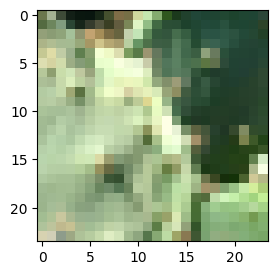

In [50]:
plt.figure(figsize=(3, 3))
plt.imshow(lowres[1]) # 저해상도 데이터셋

In [53]:
# lowres 배열에서 NumPy 배열로 데이터를 추출
lowres_numpy = lowres.numpy()

plt.imsave('./test_image/test_image1_low.png',lowres_numpy[1])

TensorShape([96, 96, 3])

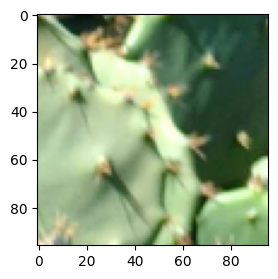

In [52]:
plt.figure(figsize=(3, 3))
plt.imshow(highres[1]) # 고해상도 데이터셋
highres[1].shape

In [54]:
# lowres 배열에서 NumPy 배열로 데이터를 추출
highres_numpy = highres.numpy()

plt.imsave('./test_image/test_image1_high.png',highres_numpy[1])

### 훈련


In [39]:
model = make_model(num_filters=64, num_of_residual_blocks=16)

In [41]:
import time

timestamp = time.strftime("%Y-%m-%d_%H-%M", time.localtime())

filename = './checkpoint/EDSR_epoch{}_{}_SGD.h5'.format(epochs,timestamp)

# optim_edsr = keras.optimizers.Adam(
#     learning_rate=keras.optimizers.schedules.PiecewiseConstantDecay(
#         boundaries=[200000], values=[1e-4, 5e-5]
#     )
# )
optim_edsr = keras.optimizers.SGD(learning_rate=1e-4)

# Compiling model with loss as mean absolute error(L1 Loss) and metric as psnr
model.compile(optimizer=optim_edsr, loss="mae", metrics=[PSNR])

callbacks = [ 
    # tensorboardm
    # tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True),
    
    # 개선된 validation score를 도출해낼 때마다 weight를 .h5타입으로 중간 저장
    # 모델을 저장할 때의 파라미터를 조정하는 것
    ModelCheckpoint(filepath=filename,
                        monitor='val_loss', # 모델을 저장할 때, 기준이 되는 값을 지정. 예를 들어, validation set의 loss가 가장 작을 때 저장하고 싶으면 'val_loss'를 입력
                        save_weights_only=False, # True인 경우, 모델의 weights만 저장됨. False인 경우, 모델 레이어 및 weights 모두 저장됨.
                        verbose=1,  # 1일 경우 모델이 저장 될 때, '저장되었습니다' 라고 화면에 표시되고, 0일 경우 화면에 표시되는 것 없이 그냥 바로 모델이 저장됨.
                        save_best_only=True,  # True 인 경우, monitor 되고 있는 값을 기준으로 가장 좋은 값으로 모델이 저장됨. False인 경우, 매 에폭마다 모델이 filepath{epoch}으로 저장된다. (model0, model1, model2....)
                        mode='auto')  # auto means automatically find the best
                        ]

# Training for more epochs will improve results
model.fit(train_ds, epochs=epochs, steps_per_epoch=500, validation_data=val_ds, callbacks=callbacks)

Epoch 1/300
500/500 [==============================] - ETA: 0s - loss: 28.6734 - PSNR: 18.7017
Epoch 1: val_loss improved from inf to 15.25089, saving model to ./checkpoint\EDSR_epoch300_2024-05-16_13-32_SGD.h5
500/500 [==============================] - 29s 45ms/step - loss: 28.6734 - PSNR: 18.7017 - val_loss: 15.2509 - val_PSNR: 22.3844
Epoch 2/300
500/500 [==============================] - ETA: 0s - loss: 15.5580 - PSNR: 22.5056
Epoch 2: val_loss improved from 15.25089 to 11.73416, saving model to ./checkpoint\EDSR_epoch300_2024-05-16_13-32_SGD.h5
500/500 [==============================] - 9s 18ms/step - loss: 15.5580 - PSNR: 22.5056 - val_loss: 11.7342 - val_PSNR: 24.5454
Epoch 3/300
500/500 [==============================] - ETA: 0s - loss: 13.6268 - PSNR: 23.8119
Epoch 3: val_loss did not improve from 11.73416
500/500 [==============================] - 9s 18ms/step - loss: 13.6268 - PSNR: 23.8119 - val_loss: 14.3094 - val_PSNR: 23.4299
Epoch 4/300
499/500 [========================

### Bicubic과 EDSR 비교(96*96)

(24, 24, 3)

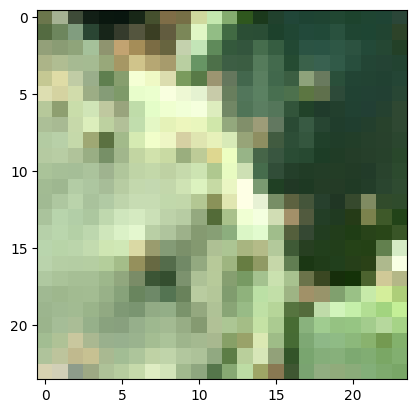

In [42]:
input_img = np.asarray(Image.open('./test_image/test_image1_low.png'))
# input_img = np.asarray(Image.open('./test_image/butterfly.png'))
plt.imshow(input_img)
input_img = input_img[:, :, :3] 
input_img.shape

(96, 96, 3)

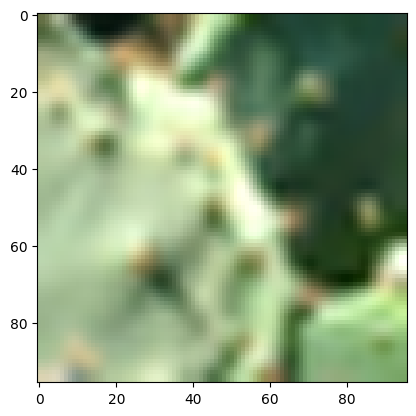

In [43]:
bicubic_img = cv2.resize(input_img,(96,96), interpolation=cv2.INTER_CUBIC)
plt.imshow(bicubic_img)
bicubic_img.shape

In [44]:
high_resolution_img = np.asarray(Image.open('./test_image/test_image1_high.png'))
# high_resolution_img = np.asarray(Image.open('./test_image/butterfly.png'))
high_resolution_img = high_resolution_img[:, :, :3] 
high_resolution_img.shape

(96, 96, 3)

In [62]:
edsr_model = keras.models.load_model('./checkpoint/EDSR_epoch500_2024-05-14_19-00.h5',custom_objects={'EDSRModel': EDSRModel, 'PSNR': PSNR})
# fsrcnn_model = keras.models.load_model('FSRCNN.h5')
# predict = model.predict(train_img) # 훈련할거 넣기

In [63]:
edsr_predict = edsr_model.predict(input_img)

(96, 96, 3)

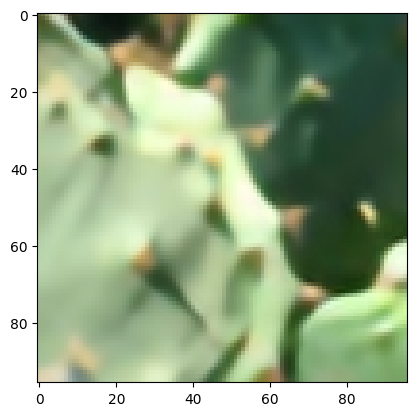

In [64]:
plt.imshow(edsr_predict)
edsr_predict.shape
# plt.imsave('edsr_butterfly.png',edsr_predict)

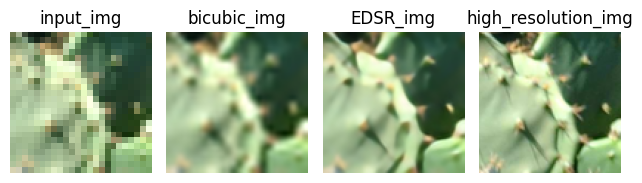

In [65]:
# 1행 2열의 서브플롯을 생성합니다.
fig, axes = plt.subplots(1, 4)

# 첫 번째 서브플롯에 이미지를 표시합니다.
axes[0].imshow(input_img)
axes[0].set_title('input_img')

# 두 번째 서브플롯에 이미지를 표시합니다.
axes[1].imshow(bicubic_img)
axes[1].set_title('bicubic_img')

# 두 번째 서브플롯에 이미지를 표시합니다.
axes[2].imshow(edsr_predict)
axes[2].set_title('EDSR_img')

# 세 번째 서브플롯에 이미지를 표시합니다.
axes[3].imshow(high_resolution_img)
axes[3].set_title('high_resolution_img')

# 각 이미지의 축을 숨깁니다.
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[3].axis('off')

# 서브플롯 간 간격을 조절합니다.
plt.tight_layout()

# 이미지를 표시합니다.
plt.show()

In [66]:
edsr_predict.shape

(96, 96, 3)

In [67]:
print(psnr2(high_resolution_img,bicubic_img))
print(psnr2(high_resolution_img,edsr_predict))


31.202020267487626
32.356298691886366


In [68]:
print(SSIM(high_resolution_img,bicubic_img))
print(SSIM(high_resolution_img,edsr_predict))


0.9751432314085072
0.9870327449206064


### BICUBIC과 EDSR 비교 (1024*1024)

(256, 256, 3)

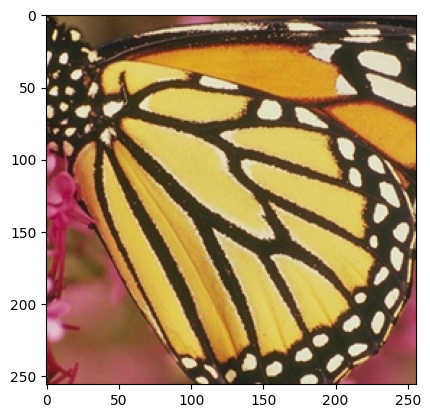

In [69]:
input_img2 = np.asarray(Image.open('./test_image/butterfly.png'))
plt.imshow(input_img2)
input_img2 = input_img2[:, :, :3] 
input_img2.shape

(1024, 1024, 3)

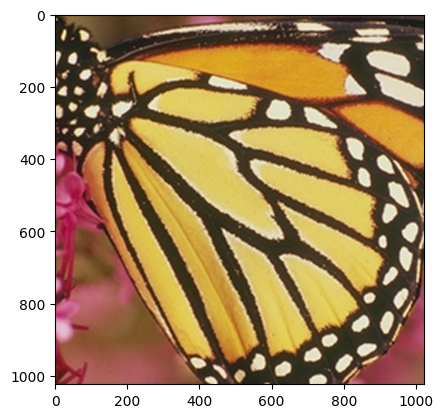

In [70]:
bicubic_img2 = cv2.resize(input_img2,(1024,1024), interpolation=cv2.INTER_CUBIC)
plt.imshow(bicubic_img2)
bicubic_img2.shape
# plt.imsave('bicubic_butterfly.png',bicubic_img2)

(1024, 1024, 3)

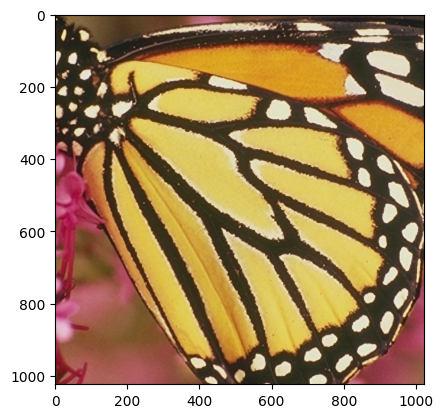

In [71]:
edsr_predict2 = edsr_model.predict(input_img2)
plt.imshow(edsr_predict2)
edsr_predict2.shape
# plt.imsave('edsr_butterfly.png',edsr_predict2)

Text(0.5, 1.0, 'edsr_img')

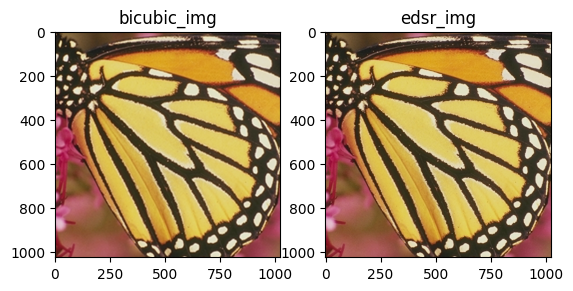

In [72]:
fig, axes = plt.subplots(1, 2)

# 첫 번째 서브플롯에 이미지를 표시합니다.
axes[0].imshow(bicubic_img2)
axes[0].set_title('bicubic_img')

# 두 번째 서브플롯에 이미지를 표시합니다.
axes[1].imshow(edsr_predict2)
axes[1].set_title('edsr_img')